# Instructions to run the Model

1. Download the repository code from the Github Repo:  https://github.com/edwardzhu0211/CS598-DLH/tree/main
2. Download and unzip the 150.ckpt onto My Drive
3. Drag and drop the contents onto My Drive - the directory should look like the image below and should take rougly 5-10 minutes to complete


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import cv2
img_dir = '/CS598-DLH-main/setup.png'
show_img(img_dir)

ModuleNotFoundError: No module named 'cv2'

# Introduction
Our problem revolves around the accurate diagnosis of COVID-19 using computed tomography (CT) images. When COVID-19 was posing an unprecedented threat, solving this issue was crucial for effectively managing the disease. The importance was further exacerbated by shortages of nucleic acid detection kits and insufficient radiologists, resulting in many patients being left undiagnosed or incorrectly diagnosed. When assessing the problem, the difficulty of it arises from the fine-grained nature of CT images, posing difficulties in classification due to low interclass variances. This makes capturing feature representation rather hard, too. State-of-the art methods, specifically convolutional neural networks (CNNs), have proven to be effective for classifications of general images and have shown promise in analyzing medical images. Feature Pyramid Network (FPN) is another method that has been successful in recognizing objects at different scales with corresponding confidence scores, addressing the challenges posed by the fine-grained nature of CT images.

The paper proposed a computer-aided diagnosis system utilizing chest CT scans to accurately distinguish between patients with viral pneumonia (COVID-19) and bacterial pneumonia, as well as to differentiate COVID-19 patients from healthy individuals. The innovations of the proposed method include a deep learning architecture, DRE-Net, which builds upon the robustness of pre-trained ResNet50 for object detection. Additionally, it incorporates the FPN to extract crucial details from regions of interest in each CT image. Local and relational features extracted from these regions are combined with global features from the original image and inputted into a multi-layer perceptron (MLP) for precise image-level prediction, enhancing the system's effectiveness in COVID-19 diagnosis. The proposed method performs well, achieving an AUC of 0.95 and an accuracy of 0.86 when discriminating COVID-19 patients from bacterial pneumonia infected patients. It also demonstrates an AUC of 0.99 and accuracy of 0.94 when discriminating COVID-19 patients from others. This contribution is significant, particularly in the context of the once-growing challenge of COVID-19 diagnosis, where traditional methods faced limitations in accuracy and efficiency. This contribution provided a valuable solution for a fast and accurate diagnosis of COVID-19, especially in times where physical resources were scarce and strained.


# Scope of Reproducibility:

Our experiment will evaluate the performance of DRE-Net in detecting COVID-19 patients through analysis of chest CT scans. Utilizing the dataset available from a public GitHub repository, which is associated with the paper, we will measure the model's performance by examining its AUC (Area Under the Curve) and accuracy metrics.

Currently with the provided code and dataset, we were only able to produce results to verify Hypothesis 1 and not Hypothesis 2. Specifically, the test dataset only included data for patients with COVID-19 and those without it. It did not contain separate data distinguishing between patients infected with COVID-19 and those infected with bacterial pneumonia. Even if that was done intentionally, this issue left us without the means to test Hypothesis 2, as the code did not include any method to handle such a testing. Therefore, we included a New Hypothesis 2 that we will be tested and assessed based on the test results used in Hypothesis 1.

Our Hypothesis based on the original papers are that:

1.   Hypothesis 1: (Ying et al., 2021) DRE-Net can accurately identify COVID-19 patients from non COVID-19 patients with an AUC of 0.99 and accuracy of 0.94.

2.   Original Hypothesis 2: (Ying et al., 2021) DRE-Net can discriminate between COVID-19 infected patients and bacterial pneumonia-infected patients with an AUC of 0.95 and accuracy of 0.86

2.   New Hypothesis 2: (Ying et al., 2021) DRE-Net performs better compared to VGG16, DenseNet, and ResNet with an AUC and accuracy value of at least 0.99 and 0.92, respectively.

# Methodology

##  Data

We chose to use the same dataset that the paper originally used to closely replicate the paper's result. The dataset contains 3D chest CT scans that came from 88 COVID-19 patients, 100 bacterial pneumonia patients, and 86 healthy individuals as shown from the image below. The data were provided by the Renmin Hospital of Wuhan University and two affiliated hospitals (the Third Affiliated Hospital and Sun Yat-Sen Memorial Hospital) of the Sun Yat-sen University in Guangzhou. We obtained access to the data-set through the following link: https://github.com/biomed-AI/COVID19-CT/tree/main/local_traniner/input

For data processing, 15 representative images containing regions of the lungs were selected per patient based on equidistant sampling (i.e.,images index [i*ntot/15, i = 0..14] with ntot as the total number images). This was done at reducing redundancy and computational load as some patients potentially had over 200 CT images to choose from. Furthermore, an OpenCV package was used to remove images with lung regions occupying less than 50 percent of the total image, ensuring uniformity across the dataset.

As a result, the refined dataset has a dataset size of 1,990 images where 777 CT images came from 88 COVID-19 patients, 505 slices came from 100 bacterial pneumonia patients, and 708 slices came from 86 healthy individuals. For the bacterial pneumonia patients and healthy individuals, their images were labeled as "no_nCoV" to represent the non COVID-19 samples. For the COVID-19 patients, their images were labeled as "nCoV" to indicate the COVID-19 samples. Roughly 39% of the dataset are labled with COVID-19, while the remaining 61% are labeled with non COVID-19 - giving us an output space of 2. Lastly, the dataset was divided into training, validation, and test sets with a ratio of 60/10/30 percent, respectively. The split was executed at the person level, meaning that all images from a single patient were exclusively assigned to one of the sets. This helps in preventing data leakage and ensures that the model's performance is evaluated on completely unseen patients.

#Sample picture of a CT scan for a Patient


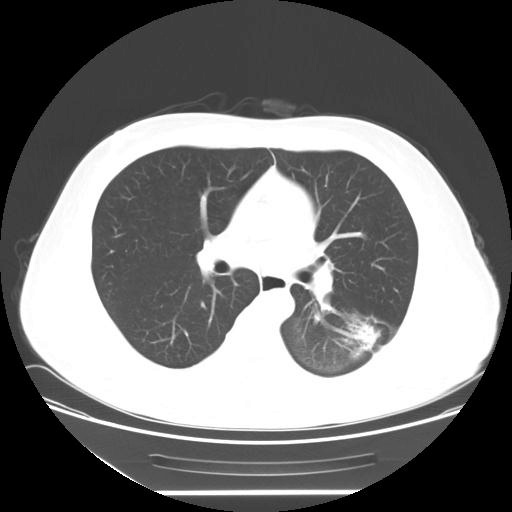

In [ ]:
img_dir = '/content/drive/My Drive/Colab Notebooks/Data/input_demo/109054_31.0.jpg'

def show_img(path):
  import cv2
  from google.colab.patches import cv2_imshow

  img = cv2.imread(img_dir)
  cv2_imshow(img)

show_img(img_dir)

## Code: Import
We imported the necessary libraries and dependencies needed to run the model.

In [ ]:

!cp /content/drive/MyDrive/config.py /content
!cp -r /content/drive/MyDrive/core/ /content/core
!cp -r /content/drive/MyDrive/utils/ /content/utils

In [ ]:
import os
import sys
import torch.utils.data
from torch.nn import DataParallel
from datetime import datetime
from torch.optim.lr_scheduler import MultiStepLR
from config import BATCH_SIZE, PROPOSAL_NUM, SAVE_FREQ, LR, WD, resume, save_dir

from core import model, dataset
from core.utils import init_log, progress_bar
import numpy as np
from sklearn.metrics import roc_auc_score
import pickle

##Code: Load the Data
We setup data loaders using data from our Google Drive that will feed the data into the model during the training, validating, and testing phases.

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
start_epoch = 1
save_dir = os.path.join(save_dir, datetime.now().strftime('%Y%m%d_%H%M%S'))
if os.path.exists(save_dir):
    raise NameError('model dir exists!')
os.makedirs(save_dir)
logging = init_log(save_dir)
_print = logging.info
train_path = '/content/drive/My Drive/Colab Notebooks/Data/train/'
val_path = '/content/drive/My Drive/Colab Notebooks/Data/val/'
test_path = '/content/drive/My Drive/Colab Notebooks/Data/test/'
trainset = dataset.SARS(root=train_path, is_train=True)
valset = dataset.SARS(root=val_path, is_train=False)
testset = dataset.SARS(root=test_path, is_train=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=2, drop_last=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=2, drop_last=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=2, drop_last=False)

##   Model


The DRE-Net model utilizes a sophisticated method for extracting and analyzing features from CT scans. At its core, it utilizes a pre-trained ResNet50 model combined with a Feature Pyramid Network (FPN) to detect potential lesion regions at various scales. For each detected region, local features are extracted to capture detailed characteristics. In addition to these local features, the model computes relational features that encapsulate the connections and spatial relationships between the identified regions. Concurrently, global features are extracted directly from the original CT image slice to provide a comprehensive overview of the lung's condition. These three types of features—local, relational, and global—are then concatenated into a unified feature set. This concatenated feature set is fed into a Multiple Layer Perceptron (MLP) to generate image-level predictions when diagnosing for COVID-19. An overview of the model can be seen in the figure below.

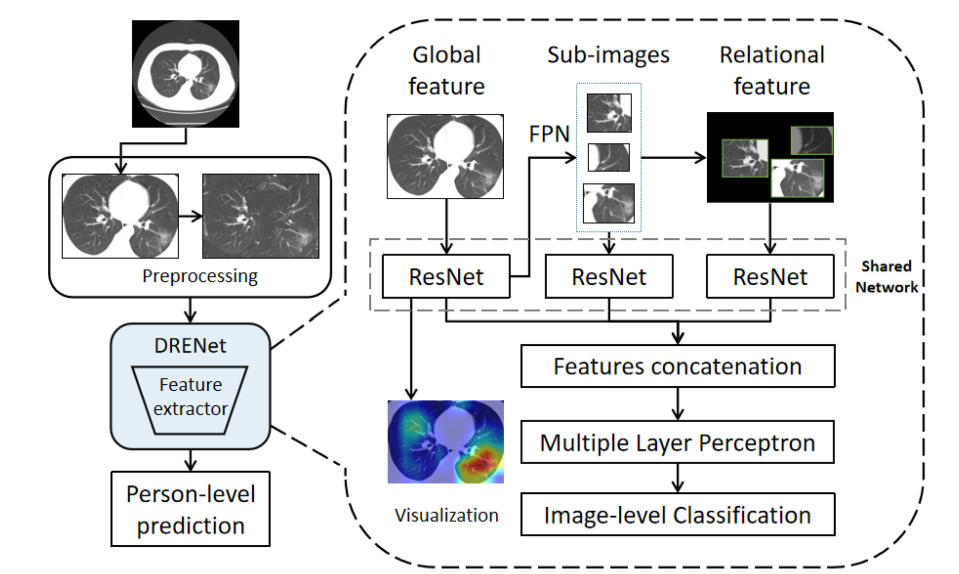

In [ ]:
img_dir = '/content/drive/My Drive/model_overview.png'
show_img(img_dir)

🔴**Model Disclaimer**🔴:

**Our model training is done outside of notebook, and the pretrained model will be loaded through the following code. This code will be ran in a different cell.**

```python
ckpt = torch.load("/content/drive/My Drive/150.ckpt", map_location=torch.device('cpu'))
net.load_state_dict(ckpt['net_state_dict'])

```

```python
ckpt = torch.load(resume)
net.load_state_dict(ckpt['net_state_dict'])
```

**Model Architecture**:

- ResNet-50 pre-trained model
- Adaptive average pooling layer (`nn.AdaptiveAvgPool2d(1)`)
- Linear layer (`nn.Linear(512 * 4, self.n_class)`) for classification

**Proposal Network**:

- `nn.Conv2d(2048, 128, 3, 1, 1)` - Convolutional layer with 2048 input channels, 128 output channels, 3x3 kernel size, stride 1, and padding 1
- `nn.Conv2d(128, 128, 3, 2, 1)` - Convolutional layer with 128 input channels, 128 output channels, 3x3 kernel size, stride 2, and padding 1
- `nn.Conv2d(128, 128, 3, 2, 1)` - Convolutional layer with 128 input channels, 128 output channels, 3x3 kernel size, stride 2, and padding 1
- `nn.ReLU()` - ReLU activation function
- `nn.Conv2d(128, 1, 1, 1, 0)` - Convolutional layer with 128 input channels, 1 output channel, 1x1 kernel size, stride 1, and padding 0 (three instances of this layer)

**Feature Combination**:

- `concat_net = nn.Linear(2048 * (CAT_NUM + 1 + 1), self.n_class)` - Linear layer for combining features
- `partcls_net = nn.Linear(512 * 4, self.n_class)` - Linear layer for processing part features

**Activation Functions**:

- ReLU activation function (`nn.ReLU()`) is used in the `ProposalNet` module.
- The code does not explicitly mention the activation functions used in the linear layers or other parts of the model.

**Other Layers/Operations**:

- Interpolation (`F.interpolate`)
- Padding (`F.pad`)
- Gathering (`torch.gather`)
- Non-maximum suppression (`hard_nms`)

The `ProposalNet` module consists of three convolutional layers with decreasing spatial dimensions (due to stride 2) and a fixed number of output channels (128). The output of these convolutional layers is then reshaped and concatenated to form the final output proposals. The ReLU activation function is applied after each convolutional layer.




**Training objectives**


**Loss Function**:
The loss function used for training is the Cross-Entropy Loss, as defined by:

```python
torch.nn.CrossEntropyLoss()

```

**Optimizers**:
The code defines four separate optimizers, each responsible for updating the parameters of different parts of the model:

1. `raw_optimizer` - Stochastic Gradient Descent (SGD) optimizer for the parameters of the pre-trained ResNet-50 model (`net.pretrained_model`).
2. `concat_optimizer` - SGD optimizer for the parameters of the `concat_net` module, which combines features for classification.
3. `part_optimizer` - SGD optimizer for the parameters of the `proposal_net` module, responsible for generating object proposals.
4. `partcls_optimizer` - SGD optimizer for the parameters of the `partcls_net` module, which processes part features for classification.

All four optimizers are initialized with the same hyperparameters:

- Learning rate (`LR`): 0.0008
- Momentum: 0.9
- Weight decay (`WD`): 1e-4

**Learning Rate Schedulers**:
The code also defines four learning rate schedulers, one for each optimizer. These schedulers are instances of `MultiStepLR`, which means the learning rate will be reduced by a factor of `gamma` at specific epochs (milestones):

- Milestones: [60, 100]
- Gamma: 0.1

This means that the learning rate will be multiplied by 0.1 (reduced by 10 times) at epochs 60 and 100.


## Code: Build the DRE-Net Model
Code implemention of DRE-Net as well as how we loaded our trained model.

In [ ]:
n_class = 2
net = model.attention_net(topN=PROPOSAL_NUM, n_class=n_class)
if resume:
    ckpt = torch.load(resume)
    net.load_state_dict(ckpt['net_state_dict'])
    start_epoch = ckpt['epoch'] + 1
creterion = torch.nn.CrossEntropyLoss()
raw_parameters = list(net.pretrained_model.parameters())
part_parameters = list(net.proposal_net.parameters())
concat_parameters = list(net.concat_net.parameters())
partcls_parameters = list(net.partcls_net.parameters())
raw_optimizer = torch.optim.SGD(raw_parameters, lr=LR, momentum=0.9, weight_decay=WD)
concat_optimizer = torch.optim.SGD(concat_parameters, lr=LR, momentum=0.9, weight_decay=WD)
part_optimizer = torch.optim.SGD(part_parameters, lr=LR, momentum=0.9, weight_decay=WD)
partcls_optimizer = torch.optim.SGD(partcls_parameters, lr=LR, momentum=0.9, weight_decay=WD)
schedulers = [MultiStepLR(raw_optimizer, milestones=[60, 100], gamma=0.1),
            MultiStepLR(concat_optimizer, milestones=[60, 100], gamma=0.1),
            MultiStepLR(part_optimizer, milestones=[60, 100], gamma=0.1),
            MultiStepLR(partcls_optimizer, milestones=[60, 100], gamma=0.1)]
if resume:
    ckpt = torch.load(resume)
    net.pretrained_model.load_state_dict({layer.replace('pretrained_model.', ''):ckpt['net_state_dict'][layer]
    for layer in ckpt['net_state_dict'] if 'pretrained_model' in layer})
    start_epoch = ckpt['epoch'] + 1

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


##Training
To train our model, we used a Virtual Machine provided by Google Cloud Platforms with the following specifications:
 * 2vCPU + 13 GB Memory
 * 1 NVIDIA Tesla P100
 * 100 GB Balanced Persistent Disk

Below is a screenshot of our code running in a Google Cloud Platform (GCP) Virtual Machine instance. In total we are running 150 epochs since the train loss curve reached a plateau, which will be shown in the Results section.


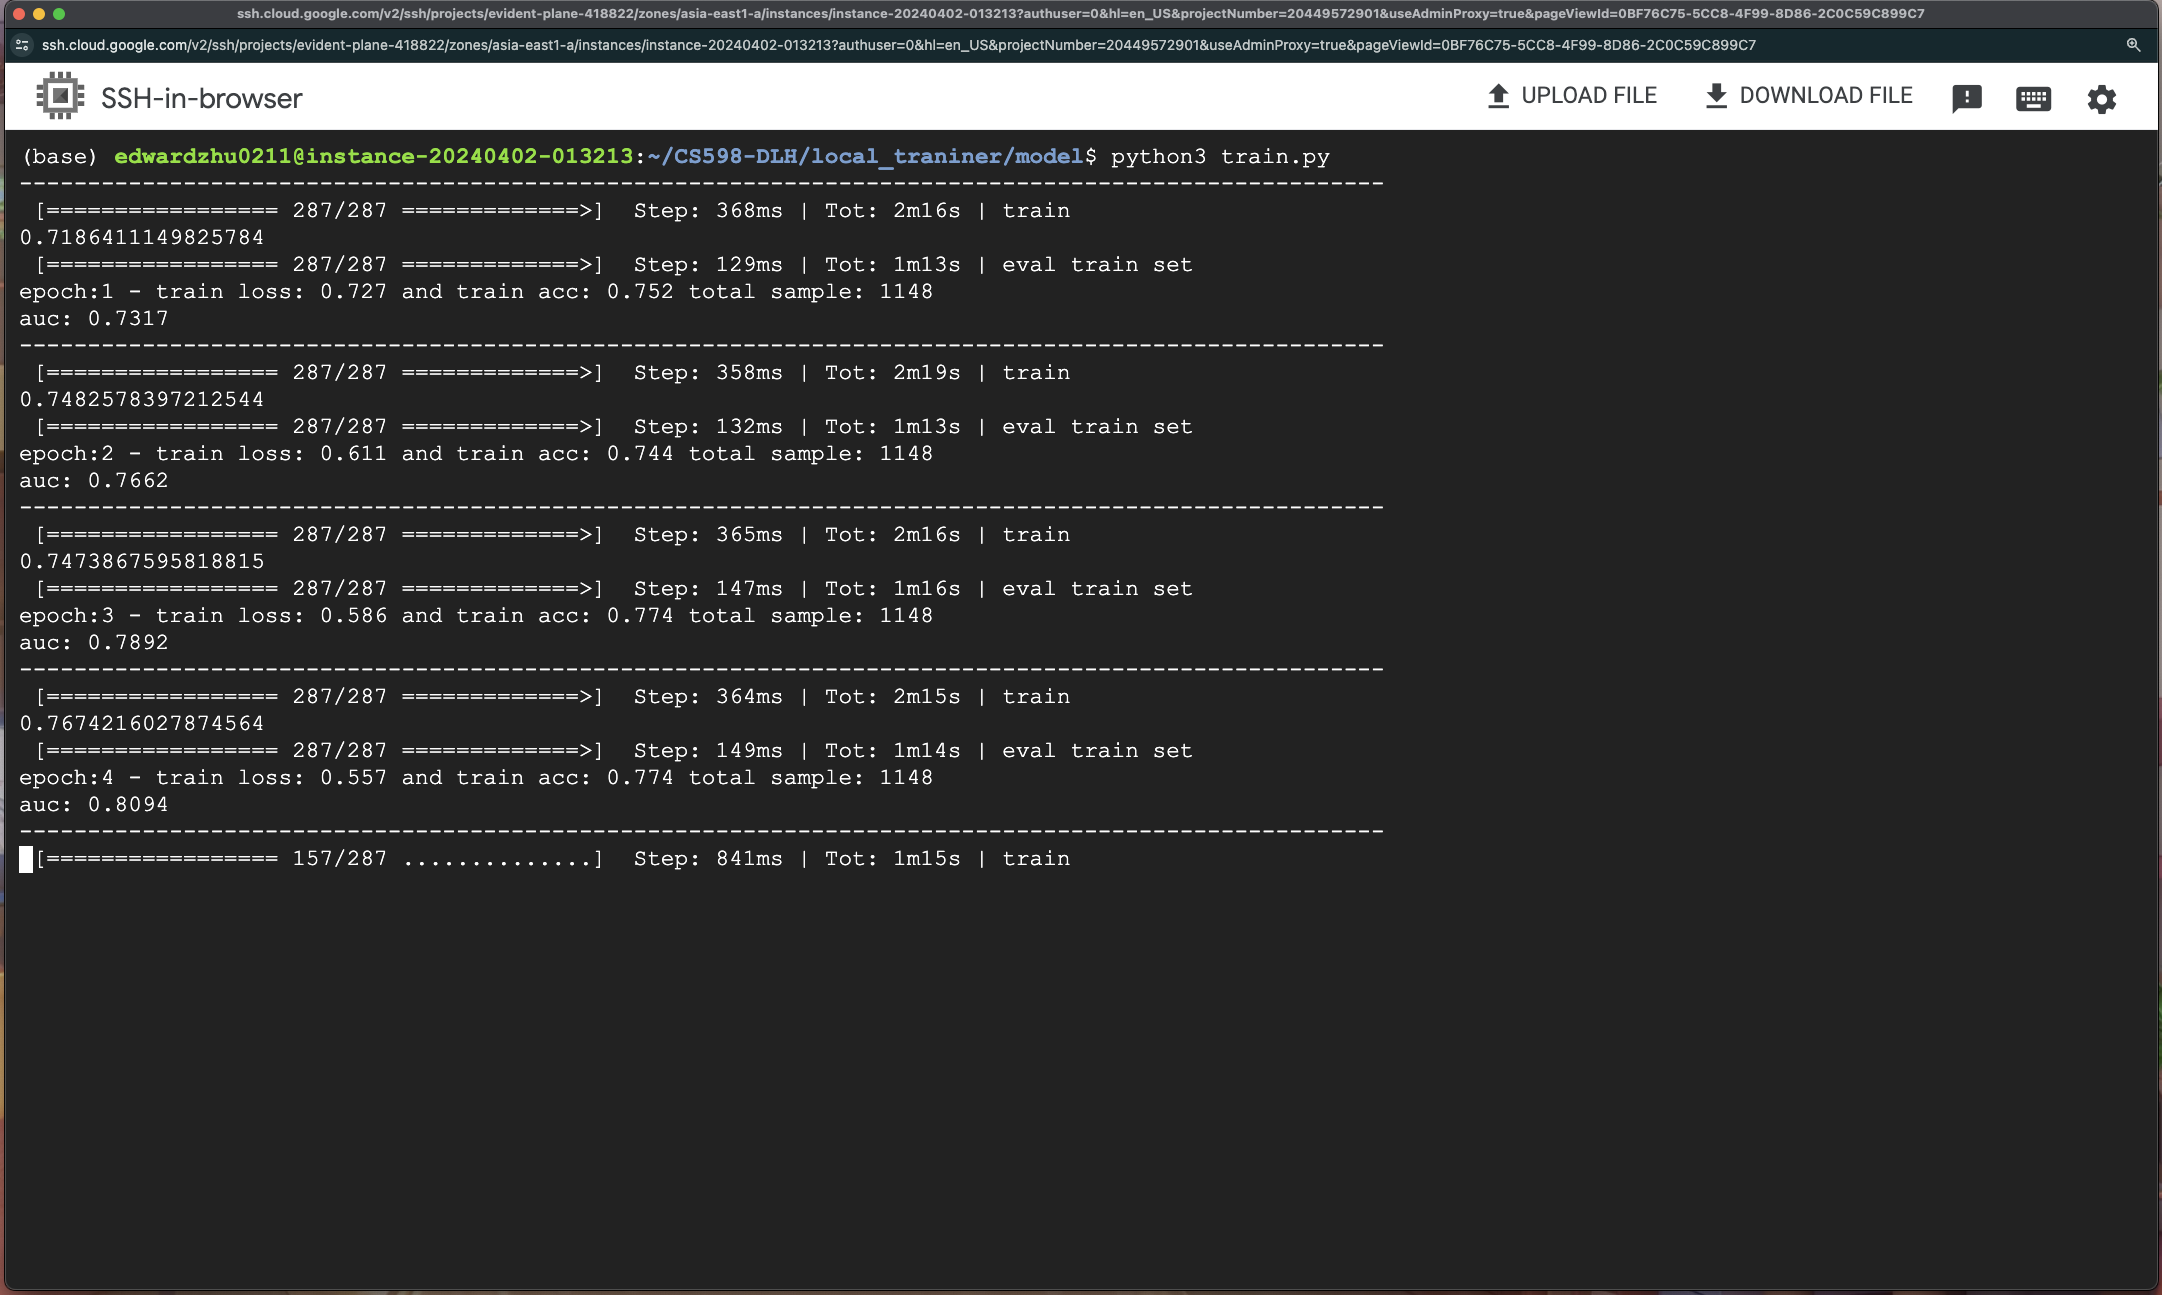

In [ ]:
img_dir = '/content/drive/My Drive/model_train_gcp.png'
show_img(img_dir)

##Code: Train the Dre-Net Model
Implementation code of training DRE-Net and saving it for each epoch.


Brief explaination of the training code:
1. **Training Loop**: The code iterates over a specified number of epochs (in this case, 2 epochs). In reality, we used 150 epochs
2. **Data Loading**: For each epoch, the code iterates over the `trainloader`, which provides batches of training data. Each batch consists of an input image (`img`), the corresponding label (`label`), and the original raw image (`img_raw`).
3. **Optimizer Initialization**: Before processing each batch, the gradients of the optimizers (`raw_optimizer`, `part_optimizer`, `concat_optimizer`, and `partcls_optimizer`) are zeroed out.
4. **Forward Pass**: The input image (`img`) and the raw image (`img_raw`) are passed through the model (`net`), which returns the raw logits (`raw_logits`), concatenated logits (`concat_logits`), part logits (`part_logits`), and top proposal probabilities (`top_n_prob`).
5. **Loss Calculation**: Several loss terms are computed:
    - `part_loss`: A loss computed using the `list_loss` function on the part logits.
    - `raw_loss`: Cross-entropy loss between the raw logits and the labels.
    - `concat_loss`: Cross-entropy loss between the concatenated logits and the labels.
    - `rank_loss`: A ranking loss computed using the `ranking_loss` function on the top proposal probabilities and the part loss.
    - `partcls_loss`: Cross-entropy loss between the part logits and the labels.
    - `total_loss`: The sum of all the above loss terms.
6. **Backward Pass**: The `total_loss` is backpropagated to update the model parameters.
7. **Optimizer Step**: The optimizers (`raw_optimizer`, `part_optimizer`, `concat_optimizer`, and `partcls_optimizer`) are stepped to update the respective model parameters.
8. **Learning Rate Scheduling**: The learning rate schedulers (`schedulers`) are stepped to adjust the learning rates according to the specified milestones and gamma values.
9. **Evaluation**: After each epoch, the model is evaluated on the validation set (`valloader`). The evaluation calculates the cross-entropy loss (`concat_loss`), accuracy (`train_acc`), and the area under the ROC curve (`roc_auc_score`). The predictions and labels are also saved as NumPy arrays.

🔴**Training Disclaimer**🔴:

**Since the dataset is too large to train in this notebook, we will only use one sample epoch for both the training and validation set**

In [ ]:
skip_epoch = 0
for epoch in range(1, 2):
    if epoch > skip_epoch:
        add = True
    else:
        add = False
    net.train()
    train_correct = 0
    total = 0
    for i, data in enumerate(trainloader):
        print("============ BEGIN TRAINING ============")
        img, label, img_raw = data[0].cpu(), data[1].cpu(), data[2]
        batch_size = img.size(0)
        raw_optimizer.zero_grad()
        part_optimizer.zero_grad()
        concat_optimizer.zero_grad()
        partcls_optimizer.zero_grad()
        raw_logits, concat_logits, part_logits, _, top_n_prob = net(img, img_raw, add)
        part_loss = model.list_loss(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                    label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1)).view(batch_size, PROPOSAL_NUM)
        raw_loss = creterion(raw_logits, label)
        concat_loss = creterion(concat_logits, label)
        rank_loss = model.ranking_loss(top_n_prob, part_loss)
        partcls_loss = creterion(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1))

        total_loss = raw_loss + rank_loss + concat_loss + partcls_loss
        total_loss.backward()
        raw_optimizer.step()
        part_optimizer.step()
        concat_optimizer.step()
        partcls_optimizer.step()
        for scheduler in schedulers:
            scheduler.step()
        progress_bar(i, len(trainloader), 'train')
        print("============ END TRAINING ============")
        break

        _, concat_predict = torch.max(concat_logits, 1)
        total += batch_size
        train_correct += torch.sum(concat_predict.data == label.data)

    pickle.dump(net, open('./model.pkl', 'wb'))
    if epoch % SAVE_FREQ == 0 :
        train_loss = 0
        train_correct = 0
        total = 0
        net.eval()
        auc_label_lst = []
        auc_pred_lst = []
        people_lst = []
        file_name_lst = []
        for i, data in enumerate(valloader):
            print("============ BEGIN VALIDATION ============")
            with torch.no_grad():
                img, label, img_raw = data[0].cpu(), data[1].cpu(), data[2]
                batch_size = img.size(0)
                _, concat_logits, _, _, _, = net(img, img_raw, add)
                concat_loss = creterion(concat_logits, label)
                _, concat_predict = torch.max(concat_logits, 1)
                auc_label_lst += list(label.data.cpu().numpy())
                pred = torch.nn.Softmax(1)(concat_logits)
                auc_pred_lst.append(pred.data.cpu().numpy())
                people_lst.append(data[3])
                file_name_lst.append(data[4])

                total += batch_size
                train_correct += torch.sum(concat_predict.data == label.data)
                train_loss += concat_loss.item() * batch_size
                progress_bar(i, len(valloader), 'eval train set')
                break;
        train_acc = float(train_correct) / total
        train_loss = train_loss / total

        print(
            'epoch:{} - train loss: {:.3f} and train acc: {:.3f} total sample: {}'.format(
                epoch,
                train_loss,
                train_acc,
                total))
        print("============ END VALIDATION ============")
        print(f'auc: {roc_auc_score(auc_label_lst, np.concatenate(auc_pred_lst, 0)[:, 1]):.4f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


============ BEGIN TRAINING ============
 [>.......................................]  Step: 1m59s | Tot: 6ms | train
      1/287 
============ END TRAINING ============
============ BEGIN VALIDATION ============
 [>.......................................]  Step: 14s264ms | Tot: 0ms | eval train set
 1/287 
epoch:1 - train loss: 0.576 and train acc: 0.750 total sample: 4
============ END VALIDATION ============
auc: 0.6667


##Evaluation


**1. Training Accuracy**:
Since this model is predicting COVID-19 from CT scans, the training accuracy represents the proportion of CT scan images that are correctly classified as COVID-positive or COVID-negative during the training phase.
While it is an important metric to monitor during training, it may not be the most reliable indicator of the model's performance on unseen data due to potential overfitting or distribution shifts between the training and testing data.


**2. Area Under the ROC Curve (AUC-ROC):**
The AUC-ROC is a particularly meaningful metric for COVID-19 prediction for CT scans because it evaluates the model's ability to distinguish between COVID-positive and COVID-negative cases across different classification thresholds.
In the context of COVID-19 diagnosis, the AUC-ROC is valuable because it accounts for the trade-off between sensitivity (correctly identifying COVID-positive cases) and specificity (correctly identifying COVID-negative cases).
A high AUC-ROC value indicates that the model can effectively separate COVID-positive and COVID-negative cases, which is crucial for accurate diagnosis and minimizing misclassifications.
Additionally, the AUC-ROC is robust to class imbalance, which is common in medical datasets, where the number of positive (COVID-positive) and negative (COVID-negative) cases may be skewed.

##Code: Evaluate the DRE-Net Model
Load the trained model to validate it against the testing data and evaluate its performance.

In [ ]:
import os
import torch.utils.data
from torch.nn import DataParallel
from datetime import datetime
from torch.optim.lr_scheduler import MultiStepLR
from config import BATCH_SIZE, PROPOSAL_NUM, SAVE_FREQ, LR, WD, resume, save_dir
from core import model, dataset
from core.utils import init_log, progress_bar
import numpy as np
from sklearn.metrics import roc_auc_score
import pickle


test_loss = 0
test_correct = 0
total = 0
auc_label_lst = []
auc_pred_lst = []
people_lst = []
img_vis_lst = []
file_name_lst = []
anchor_lst = []

test_loss = 0
test_correct = 0
total = 0

n_class = 2
net = model.attention_net(topN=PROPOSAL_NUM, n_class=n_class)

# load the model we trained in gcp
ckpt = torch.load("/content/drive/My Drive/150.ckpt", map_location=torch.device('cpu'))
net.load_state_dict(ckpt['net_state_dict'])



test_path = '/content/drive/My Drive/Colab Notebooks/Data/test/'
testset = dataset.SARS(root=test_path, is_train=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=2,
                                            shuffle=False, num_workers=2, drop_last=False)
creterion = torch.nn.CrossEntropyLoss()


for epoch in range(1, 2):
  for i, data in enumerate(testloader):
      print("============ BEGIN TESTING ============")
      with torch.no_grad():
          img, label, img_raw = data[0].cpu(), data[1].cpu(), data[2]
          batch_size = img.size(0)
          _, concat_logits, _, _, _ = net(img, img_raw, False, False)
          concat_loss = creterion(concat_logits, label)
          _, concat_predict = torch.max(concat_logits, 1)
          auc_label_lst += list(label.data.cpu().numpy())
          pred = torch.nn.Softmax(1)(concat_logits)
          auc_pred_lst.append(pred.data.cpu().numpy())
          total += batch_size
          test_correct += torch.sum(concat_predict.data == label.data)
          test_loss += concat_loss.item() * batch_size
          progress_bar(i, len(testloader), 'eval test set')
          break
  test_acc = float(test_correct) / total
  test_loss = test_loss / total
  print(f'auc: {roc_auc_score(auc_label_lst, np.concatenate(auc_pred_lst, 0)[:, 1]):.4f}')
  print(f'Test acc: {test_acc}')
  print(f'Test loss; {test_loss}')
print("============ END TESTING ============")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


============ BEGIN TESTING ============
 [>.......................................]  Step: 29s675ms | Tot: 8ms | eval test set
 1/284 
============ END TESTING ============


# Results

Our results are as follows for Hypothesis 1 and New Hypothesis 2:

\

| Model      | AUC | Accuracy |
| ----------- | ----------- |-----------
| VGG16      | 0.98       | 0.90
| DenseNet   | 0.97        | 0.92
| ResNet   | 0.99        | 0.92
| Dre-Net   | 0.99        | 0.94
| Replicated Dre-Net (our model)   | 0.87  | 0.80

\

Due to computational constraints and the resources required, our training was limited to 150 epochs, as opposed to the 500 epochs detailed in the original paper. However as seen in the loss curve below, the training loss would plateau so lowering epoch was beneficial.

Looking at the table, we achieved an AUC of 0.87 and an accuracy of 0.80, which unfortunently is lower than the paper's result with a decrease in AUC of 0.12 and in accuracy of 0.14. Thus, our Dre-Net could not identify COVID-19 patients from non COVID-19 patients with the claimed AUC and accuracy values. As compared to the other models, Dre-Net couldn't perform better than VGG16, DenseNet, and Resnet as claimed. Specifically, our values were the lowest with the greatest difference among the models being 0.12 in AUC and 0.12 in accuracy.

Although our test results are not optimal and our findings refute the paper's claim, the result can be improved and be more closely aligned with the original results given more processing power and code rewrite, which will further be expanded in the next section. As seen in the figures below, the train accuracy and train loss curve show a positive trend in our model being effective in identifying between COVID-19 and non COVID-19 patients. Train loss is decreasing while train accuracy is increasing as the model is being trained over more epochs - indicating our model is executing as intended. For now, the results are not in agreement with the Hypothesis 1 and the New Hypothesis 2 posed earlier, however the AUC and accuracy values will still do a good job in prediction as shown in our Demo Section.


##Code: Test Results

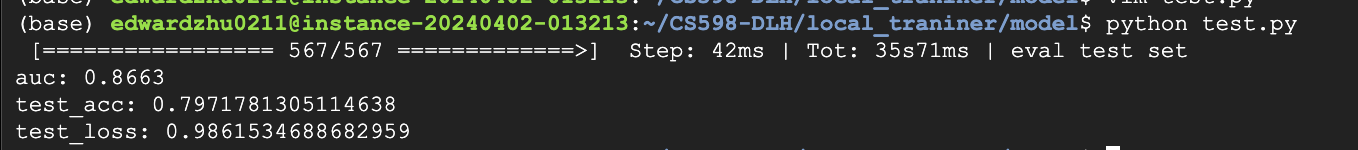

In [ ]:
# test results
img_dir = '/content/drive/My Drive/test_result.png'
show_img(img_dir)

##Code: Train Results and Loss Curves

In [ ]:
import matplotlib.pyplot as plt

# results from the training data
with open('/content/drive/My Drive/log.log', 'r') as file:
    lines = file.readlines()

epochs = []
train_losses = []
train_accuracies = []

for line in lines:
    line = line.split()
    if len(line) == 14:
        epochs.append(line[2])
        train_losses.append(line[6])
        train_accuracies.append(line[10])

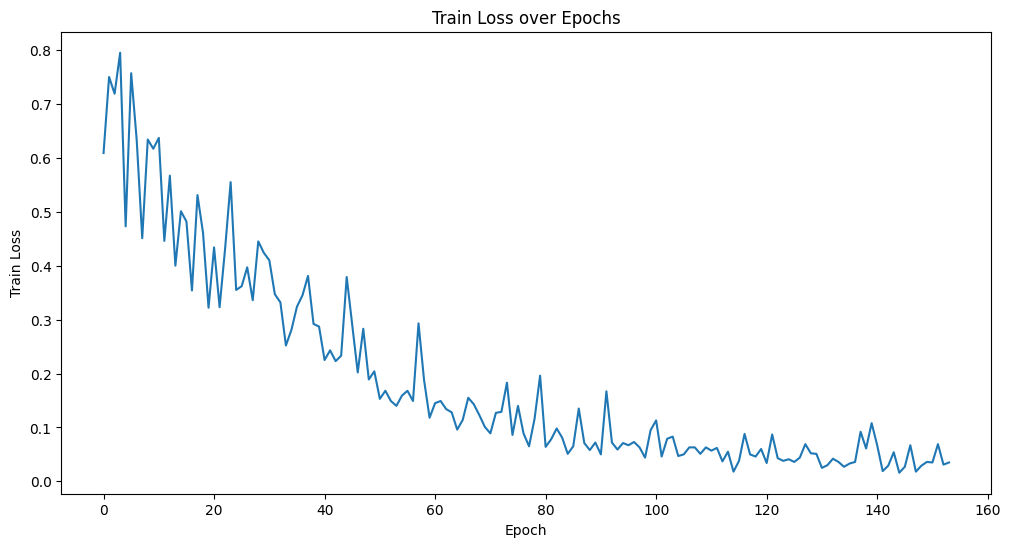

In [ ]:
data = [float(x) for x in train_losses]
x = list(range(len(data)))

plt.figure(figsize=(12, 6))
plt.plot(x, data)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.show()

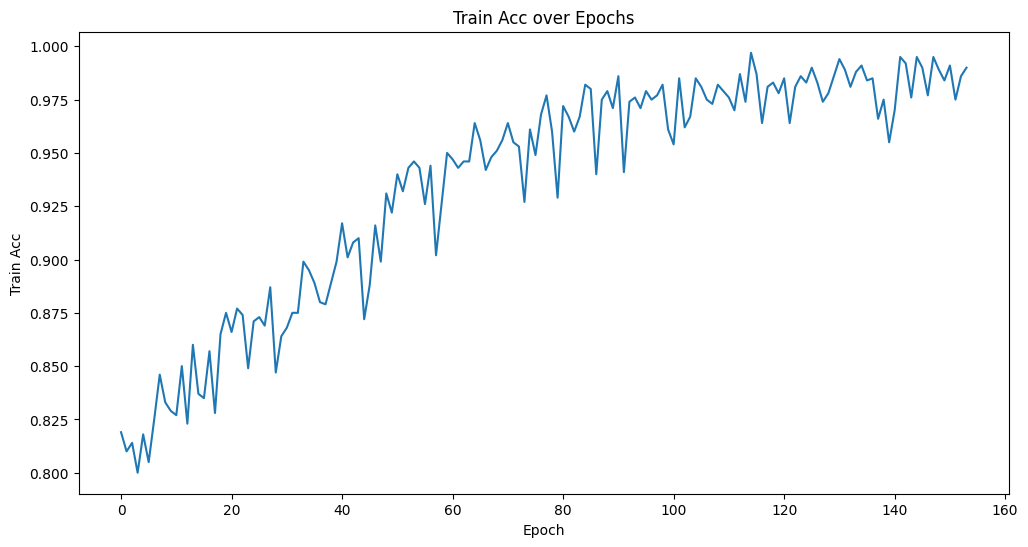

In [ ]:
data = [float(x) for x in train_accuracies]
x = list(range(len(data)))

plt.figure(figsize=(12, 6))
plt.plot(x, data)
plt.xlabel('Epoch')
plt.ylabel('Train Acc')
plt.title('Train Acc over Epochs')
plt.show()

# Discussion



Our attempts to reproduce the findings of the paper were partially successful. Although the model was successfully executed, our results did not fully match the reported outcomes. We achieved a test AUC of 0.87 and a test accuracy of 0.80, which are lower than the paper's reported metrics of a test AUC of 0.99 and a test accuracy of 0.94 and lower than the other models that were compared against.


The reason for the shortcoming can be attributed to a difference in our code from that of the original paper. Specifically, the paper conducted training and testing within the same epoch as part of a singular loop, while our approach involved completing the training over the full number of epochs first before proceeding to the testing phase. This decision was caused by our limited computational resources, leading us to prioritize fully training and saving the model first before conducting tests as a necessary compromise.


In terms of difficulty, refactoring the code from the paper proved to be a significant challenge. The original code relied on packages that are now outdated and deprecated, requiring us to update the entire code extensively. Furthermore,the model demanded significant computational resources to run effectively, leading to challenges in securing a virtual machine with sufficient computational power at a cost-effective rate.


On the other hand, what was easy was that the model's architecture was straightforward to comprehend due to the detailed diagram provided in the paper, which clearly outlined each significant component. This illustration was instrumental in helping us understand the overall structure. Additionally, the code supplied with the paper was invaluable during the coding phase. The code's clarity and structured organization made it easy to navigate. The authors adhered to naming conventions for variables, enhancing the code's readability and its ability to convey its purpose.


To improve reproducibility, we recommend to the author to include a section that outlines the necessary computational requirements for replicating the results. This section should clarify the minimum hardware specifications needed and suggest options for virtual machines that can offer these resources in a cost effective manner. This guidance would aid reproducers in setting up their environments efficiently. Furthermore, we recommend adding a section dedicated to alternative methodologies suitable for individuals with limited computational resources. Given that not all reproducers will have access to the required computational resources, it's important to offer modifications to the model that can adapt to these constraints. This could include guidelines on adjusting the number of epochs and batch size to successfully replicate the paper's results.


In our next phase, we plan to start our ablation study. This study consists of removing one of the three features in the DRE-Net Model - Local, Relational, and Global. These features are first concatenated before being fed into a Multiple Layer Perceptron (MLP) for image-level prediction. By running the model without one of the features, it will let us determine which feature significantly influences the overall performance of the model. In addition, we plan on running the model as originally designed by performing both the training and testing within the same epoch. We hope that this approach will help us replicate the results presented in the paper.




# Demo

In this section we are testing our model against two patients (one with COVID and one without COVID)

In [ ]:
import sys
import torch
import os
use_gpu = True
if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    # assert 0, 'Please check gpu is available!'
    use_gpu = False
import numpy as np
from utils.dataset import SARS
from utils.model import attention_net as net
from utils.model import get_xy, draw
from utils.pre_cut_lungs import get_segmented_lungs
from PIL import Image

In [ ]:
def run_preprocess(path):
    vis_img_lst = []
    test_lst = []
    img_fp = []
    for fn in os.listdir(path):
        fp = os.path.join(path, fn)
        flg, test_img, train_img = get_segmented_lungs(fp)
        if not flg:
            continue
        vis_img_lst.append(train_img)
        test_lst.append(test_img)
        img_fp.append(fp)
    return test_lst, vis_img_lst, img_fp


def run_model(img_lst, vis_img_lst, img_fp):
    model = net(topN=6, n_class=2, use_gpu=use_gpu)
    if use_gpu:
        model.load_state_dict(torch.load('./model.ckpt')['net_state_dict'])
        model = model.cuda()
    else:
        # using our own model here
        model.load_state_dict(torch.load('/content/drive/My Drive/150.ckpt', map_location='cpu')['net_state_dict'])
    model.eval()
    loader = load_data(img_lst)

    pred_lst = []
    anchor_lst = []
    for i, data in enumerate(loader):
        if use_gpu:
            img, img_raw = data[0].cpu(), data[2].cpu()
        else:
            img, img_raw = data[0], data[2]
        with torch.no_grad():
            _, concat_logits, _, _, _, anchor = model(img, img_raw, True, True)
        # calculate accuracy
        pred = torch.nn.Softmax(1)(concat_logits)
        pred_lst.append(pred.data.cpu().numpy())
        anchor_lst.append(anchor)
    pred_lst = np.concatenate(pred_lst, 0)
    anchor_lst = np.concatenate(anchor_lst, 0)

    T = 3
    topk = 6
    score = anchor_lst[:, 0, 0].reshape(-1)
    rank = [index for index, value in
            sorted(list(enumerate(score)), key=lambda x: x[1], reverse=True)]
    rank = rank[:topk]
    counter_save = 0
    for i in rank:
        fp = img_fp[i]
        img = vis_img_lst[i].transpose(2,0,1)
        y, x = img.shape[1], img.shape[2]
        flg = 0
        for j in range(anchor_lst.shape[1]):
            if anchor_lst[i][j][0] < T:
                continue
            flg = 1
            [y0, x0, y1, x1] = anchor_lst[i, j, 1:5].astype(int)
            y0, x0, y1, x1 = get_xy(y0, x0, y1, x1)
            y0 = int((y0-224)*y/448)
            x0 = int((x0-224)*x/448)
            y1 = int((y1-224)*y/448)
            x1 = int((x1-224)*x/448)
            img = draw(img, y0, x0, y1, x1)
        if flg == 0:
            continue
        img = img.transpose(1,2,0)
        img = Image.fromarray(img, 'RGB')
        end = '.'+fp.split('.')[-1]
        save_fp = fp.replace(end, '_vis.jpg')
        img.save(save_fp)
        counter_save += 1
    while counter_save == 0:
        T -= 0.3
        counter_save = 0
        for i in rank:
            fp = img_fp[i]
            img = vis_img_lst[i].transpose(2,0,1)
            y, x = img.shape[1], img.shape[2]
            flg = 0
            for j in range(anchor_lst.shape[1]):
                if anchor_lst[i][j][0] < T:
                    continue
                flg = 1
                [y0, x0, y1, x1] = anchor_lst[i, j, 1:5].astype(int)
                y0, x0, y1, x1 = get_xy(y0, x0, y1, x1)
                y0 = int((y0-224)*y/448)
                x0 = int((x0-224)*x/448)
                y1 = int((y1-224)*y/448)
                x1 = int((x1-224)*x/448)
                img = draw(img, y0, x0, y1, x1)
            if flg == 0:
                continue
            img = img.transpose(1,2,0)
            img = Image.fromarray(img, 'RGB')
            end = '.'+fp.split('.')[-1]
            save_fp = fp.replace(end, '_vis.jpg')
            img.save(save_fp)
            counter_save += 1
    return list(pred_lst[:, 1])


def run_people_level_prediction(pred_lst):
    return np.mean(pred_lst)


def load_data(img_lst, BATCH_SIZE=4):
    dataset = SARS(img_lst=img_lst, is_train=False)
    loader = torch.utils.data.DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, drop_last=False)
    return loader


def main(path):
    img_lst, vis_img_lst, img_fp = run_preprocess(path)
    pred_lst = run_model(img_lst, vis_img_lst, img_fp)
    result = run_people_level_prediction(pred_lst)
    return result


if __name__ == '__main__':
    base_path = "/content/drive/My Drive/Colab Notebooks/Data/input_demo/"
    person1 = "/content/drive/My Drive/Colab Notebooks/Data/input_demo/person001_COVID19"
    person2 = "/content/drive/My Drive/Colab Notebooks/Data/input_demo/person002_non-COVID19"
    paths = [person1, person2]

    for i, path in enumerate(paths):
      result = main(path)
      print('{prediction:'+f'{result:.2f}'+'}')
      if result > 0.8:
        print(f'Person {i+1} has COVID-19')
      else:
        print(f'Person {i+1} does not have COVID-19')

{prediction:0.94}
Person 1 has COVID-19
{prediction:0.73}
Person 2 does not have COVID-19


# References
1.   Y. Song et al, "Deep Learning Enables Accurate Diagnosis of Novel Coronavirus (COVID-19) With CT Images", IEEE/ACM Transactions on Computational Biology and Bioinformatics, 2021, vol. 18:no. 6, doi: 10.1109/TCBB.2021.3065361.





